<h1>Convolutional Neural Network with Batch-Normalization </h1>


<h2>Preparation</h2>


In [1]:

# Import the libraries we need to use in this lab

# Using the following line code to install the torchvision library
# !mamba install -y torchvision

# !pip install torchvision==0.9.1 torch==1.8.1

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

<h2 id="Makeup_Data">Get the Data</h2>


In [2]:

IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [3]:

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5215192.96it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 151416.97it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:03<00:00, 536968.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2976180.09it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Make the validating

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [5]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

In [6]:
# The label for the fourth data element

train_dataset[3][1]

1

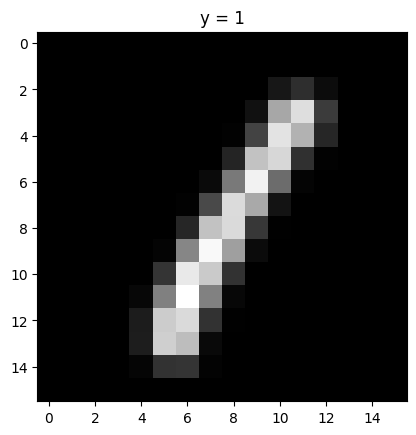

In [7]:
# The image for the fourth data element
show_data(train_dataset[3])


<h2 id="CNN">Build a Two Convolutional Neural Network Class</h2>


Build a Convolutional Network class with two Convolutional layers without Batch-Normalization

In [8]:
class CNN(nn.Module):

    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


Build a Convolutional Network class with two Convolutional layers with Batch-Normalization


In [9]:
class CNN_batch(nn.Module):

    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x

In [10]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):

    #global variable
    N_test=len(validation_dataset)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)

        correct=0
        #perform a prediction on the validation  data
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)

    return accuracy_list, loss_list

<h2 id="Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</h2>


In [11]:
# Create the model object using CNN class
model = CNN(out_1=16, out_2=32)

In [12]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [13]:
# Train the model
accuracy_list_normal, loss_list_normal=train_model(model=model,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

In [14]:
model_batch=CNN_batch(out_1=16, out_2=32)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)
accuracy_list_batch, loss_list_batch=train_model(model=model_batch,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

<h2 id="Result">Analyze Results</h2>


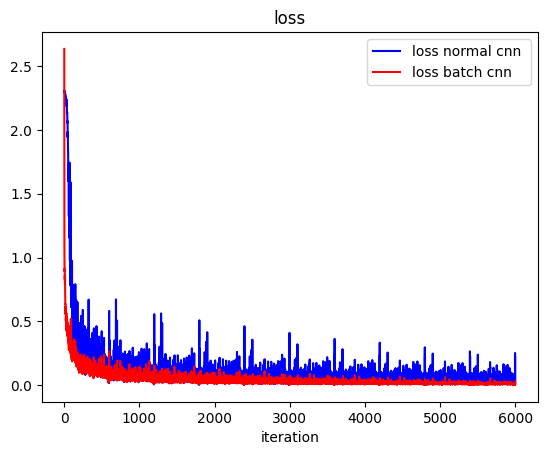

In [15]:
# Plot the loss and accuracy

plt.plot(loss_list_normal, 'b',label='loss normal cnn ')
plt.plot(loss_list_batch,'r',label='loss batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()

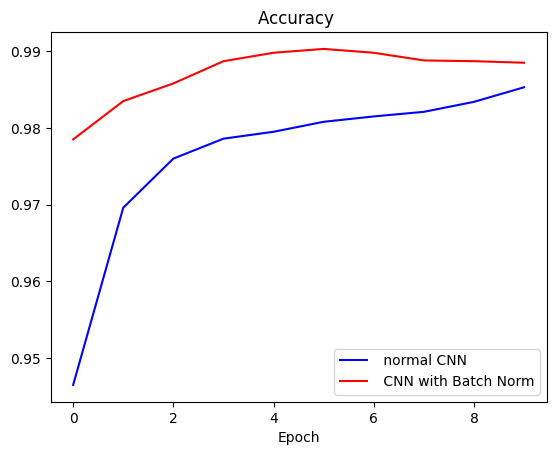

In [16]:
plt.plot(accuracy_list_normal, 'b',label=' normal CNN')
plt.plot(accuracy_list_batch,'r',label=' CNN with Batch Norm')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()